# NLP HW1 Mert YILDIZ

## Preprocessing

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
torch.manual_seed(1)
from gensim.models import KeyedVectors

from sklearn.metrics import classification_report

In [4]:
#### Train Data Preparation
tokens_s = []
labels_s = []

tokens = []
labels = []
path = '/content/drive/MyDrive/data/train.tsv'

with open(path) as f:

    for line in f:

        line = line.strip()

        if line.startswith("#\t"):
            tokens = []
            labels = []
        elif line == "":
            tokens_s.append(tokens)
            labels_s.append(labels)
        else:
            token, label = line.split("\t")
            tokens.append(token)
            labels.append(label)

assert len(tokens_s) == len(labels_s)

df_train = pd.DataFrame(columns = ["sentence","tokens","labels"])
df_train["tokens"] = tokens_s
df_train["labels"] = labels_s
df_train["sentence"] =  df_train.index

#### Dev Data Preparation
tokens_s = []
labels_s = []

tokens = []
labels = []
path = '/content/drive/MyDrive/data/dev.tsv'

with open(path) as f:

    for line in f:

        line = line.strip()

        if line.startswith("#\t"):
            tokens = []
            labels = []
        elif line == "":
            tokens_s.append(tokens)
            labels_s.append(labels)
        else:
            token, label = line.split("\t")
            tokens.append(token)
            labels.append(label)

assert len(tokens_s) == len(labels_s)

df_dev = pd.DataFrame(columns = ["sentence","tokens","labels"])
df_dev["tokens"] = tokens_s
df_dev["labels"] = labels_s
df_dev["sentence"] =  df_dev.index

In [5]:
df_train.head()

,sentence,tokens,labels
0,0,"[it, lies, approximately, north, east, of, bol...","[O, O, O, O, O, O, B-LOC, O, O, O, O, O, O, O,..."
1,1,"[does, anybody, really, know, what, time, it, ...","[B-CW, I-CW, I-CW, I-CW, I-CW, I-CW, I-CW, I-C..."
2,2,"[amrish, puri, ,, anupam, kher, ,, mukesh, kha...","[B-PER, I-PER, O, B-PER, I-PER, O, B-PER, I-PE..."
3,3,"[wilds, himself, later, said, that, he, was, c...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
4,4,"[he, scored, the, first, goal, of, a, famous, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


In [6]:
df_dev.head()

,sentence,tokens,labels
0,0,"[on, the, day, of, the, referendum, michael, a...","[O, O, O, O, O, O, B-PER, I-PER, O, O, O, O, O..."
1,1,"[rpms, are, often, collected, centrally, in, o...","[O, O, O, O, O, O, O, O, O, B-CW, I-CW, O, O, ..."
2,2,"[in, 1991, he, played, for, two, teams, ,, the...","[O, O, O, O, O, O, O, O, O, B-GRP, I-GRP, O, O..."
3,3,"[the, original, game, was, released, for, ms-d...","[O, O, O, O, O, O, B-CW, O, O, O, B-PROD, I-PR..."
4,4,"[it, was, the, seventh, edition, conducted, by...","[O, O, O, O, O, O, O, O, B-GRP, I-GRP, I-GRP, ..."


In [7]:
def prepare_sequence(seq, to_ix):
    idxs = []
    for w in seq:
        try:
            idxs.append(to_ix[w])
        except:
            idxs.append(to_ix['<UNK>'])

        
    return torch.tensor(idxs, dtype=torch.long)

training_data = []
for i in range(len(df_train)):
    row = df_train.iloc[i]
    training_data.append((row["tokens"], row["labels"]))

dev_data = []
for i in range(len(df_dev)):
    row = df_dev.iloc[i]
    dev_data.append((row["tokens"], row["labels"]))

word_to_ix = {}
# For each words-list (sentence) and tags-list in each tuple of training_data
for sent, tags in training_data:
    for word in sent:
        if word not in word_to_ix:  # word has not been assigned an index yet
            word_to_ix[word] = len(word_to_ix)  # Assign each word with a unique index

word_to_ix['<UNK>'] = len(word_to_ix)
print(word_to_ix)

tag_to_ix = {} 
# For each words-list (sentence) and tags-list in each tuple of training_data
for sent, tags in training_data:
    for tag in tags:
        if tag not in tag_to_ix:  # word has not been assigned an index yet
            tag_to_ix[tag] = len(tag_to_ix)  # Assign each word with a unique index
print(tag_to_ix)

{'it': 0, 'lies': 1, 'approximately': 2, 'north': 3, 'east': 4, 'of': 5, 'bolesławiec': 6, ',': 7, 'and': 8, 'west': 9, 'the': 10, 'regional': 11, 'capital': 12, 'wrocław': 13, '.': 14, 'does': 15, 'anybody': 16, 'really': 17, 'know': 18, 'what': 19, 'time': 20, 'is?': 21, '(': 22, 'single': 23, 'version': 24, ')': 25, 'lamm': 26, '–': 27, '3': 28, ':': 29, '19': 30, 'amrish': 31, 'puri': 32, 'anupam': 33, 'kher': 34, 'mukesh': 35, 'khanna': 36, 'dalip': 37, 'tahil': 38, 'gulshan': 39, 'grover': 40, 'dina': 41, 'pathak': 42, 'jackie': 43, 'shroff': 44, 'are': 45, 'also': 46, 'featured': 47, 'in': 48, 'movie': 49, 'wilds': 50, 'himself': 51, 'later': 52, 'said': 53, 'that': 54, 'he': 55, 'was': 56, 'coached': 57, 'to': 58, 'say': 59, 'first': 60, 'saw': 61, 'victim': 62, "'s": 63, 'body': 64, 'at': 65, 'a': 66, 'certain': 67, 'best': 68, 'buy': 69, 'scored': 70, 'goal': 71, 'famous': 72, 'second': 73, 'leg': 74, 'home': 75, 'comeback': 76, 'victory': 77, 'over': 78, 'great': 79, 'a.c.':

## Baseline

In [ ]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):

        super(LSTMTagger, self).__init__()

        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)


        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores


EMBEDDING_DIM = 300
HIDDEN_DIM = 300
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_to_ix)).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)


# See what the scores are before training
# Note that element i,j of the output is the score for tag j for word i.
# Here we don't need to train, so the code is wrapped in torch.no_grad()

for epoch in range(5):  # again, normally you would NOT do 300 epochs, it is toy data
    for sentence, tags in tqdm(training_data):
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is, turn them into
        # Tensors of word indices.
        sentence_in = prepare_sequence(sentence, word_to_ix).to(device)
        targets = prepare_sequence(tags, tag_to_ix).to(device)

        # Step 3. Run our forward pass.
        tag_scores = model(sentence_in)

        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()
    print(loss)

100%|██████████| 14535/14535 [01:17<00:00, 186.92it/s]


tensor(0.2332, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 14535/14535 [01:15<00:00, 193.38it/s]


tensor(0.1595, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 14535/14535 [01:18<00:00, 184.31it/s]


tensor(0.1085, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 14535/14535 [01:15<00:00, 193.70it/s]


tensor(0.1756, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 14535/14535 [01:06<00:00, 218.75it/s]


tensor(0.1073, device='cuda:0', grad_fn=<NllLossBackward0>)


In [ ]:
def predict(indices):    
    for index in range(len(indices)):
        with torch.no_grad():
            inputs = prepare_sequence(dev_data[index][0], word_to_ix)
            inputs = inputs.to(device)
            tag_scores = model(inputs)
        values, target = torch.max(tag_scores, 1)
        target = np.array(target.to('cpu'))
        yield target

y_pred = list(predict([s for s, t in dev_data]))
y_true = [t for s, t in dev_data]

y_true_indexed = []
for tag in y_true:
    tag_lst=[]
    for i in tag:
        tag_lst.append(tag_to_ix[i])

    y_true_indexed.append(tag_lst)
y_true = y_true_indexed

tag_lst=[]
for tag in y_true:

    for i in tag:
        tag_lst.append(i)

tag_lst_pred=[]
for tag in y_pred:

    for i in tag:
        tag_lst_pred.append(i)

report = classification_report(tag_lst, tag_lst_pred, target_names=tag_to_ix.keys())
print(report)

              precision    recall  f1-score   support

           O       0.91      0.98      0.94     10240
       B-LOC       0.66      0.58      0.62       243
        B-CW       0.46      0.25      0.32       170
        I-CW       0.62      0.33      0.43       261
       B-PER       0.74      0.58      0.65       300
       I-PER       0.81      0.60      0.69       329
      B-CORP       0.52      0.38      0.44       133
      I-CORP       0.66      0.61      0.63       119
       B-GRP       0.69      0.41      0.51       190
       I-GRP       0.85      0.65      0.74       377
      B-PROD       0.53      0.27      0.36       149
      I-PROD       0.76      0.37      0.50        87
       I-LOC       0.80      0.40      0.53       153

    accuracy                           0.88     12751
   macro avg       0.69      0.49      0.57     12751
weighted avg       0.87      0.88      0.87     12751



## BiLSTM Model

In [ ]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):

        super(LSTMTagger, self).__init__()

        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)


        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim,bidirectional=True)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim*2, tagset_size)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores


EMBEDDING_DIM = 300
HIDDEN_DIM = 300
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_to_ix)).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)


# See what the scores are before training
# Note that element i,j of the output is the score for tag j for word i.
# Here we don't need to train, so the code is wrapped in torch.no_grad()

for epoch in range(5):  # again, normally you would NOT do 300 epochs, it is toy data
    for sentence, tags in tqdm(training_data):
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is, turn them into
        # Tensors of word indices.
        sentence_in = prepare_sequence(sentence, word_to_ix).to(device)
        targets = prepare_sequence(tags, tag_to_ix).to(device)

        # Step 3. Run our forward pass.
        tag_scores = model(sentence_in)

        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()
    print(loss)

100%|██████████| 14535/14535 [01:23<00:00, 174.62it/s]


tensor(0.3824, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 14535/14535 [01:23<00:00, 173.63it/s]


tensor(0.4313, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 14535/14535 [01:23<00:00, 174.80it/s]


tensor(0.3978, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 14535/14535 [01:24<00:00, 172.89it/s]


tensor(0.2515, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 14535/14535 [01:24<00:00, 171.51it/s]

tensor(0.0458, device='cuda:0', grad_fn=<NllLossBackward0>)


In [ ]:
def predict(indices):    
    for index in range(len(indices)):
        with torch.no_grad():
            inputs = prepare_sequence(dev_data[index][0], word_to_ix)
            inputs = inputs.to(device)
            tag_scores = model(inputs)
        values, target = torch.max(tag_scores, 1)
        target = np.array(target.to('cpu'))
        yield target

y_pred = list(predict([s for s, t in dev_data]))
y_true = [t for s, t in dev_data]

y_true_indexed = []
for tag in y_true:
    tag_lst=[]
    for i in tag:
        tag_lst.append(tag_to_ix[i])

    y_true_indexed.append(tag_lst)
y_true = y_true_indexed

tag_lst=[]
for tag in y_true:

    for i in tag:
        tag_lst.append(i)

tag_lst_pred=[]
for tag in y_pred:

    for i in tag:
        tag_lst_pred.append(i)

report = classification_report(tag_lst, tag_lst_pred, target_names=tag_to_ix.keys())
print(report)

              precision    recall  f1-score   support

           O       0.93      0.97      0.95     10240
       B-LOC       0.86      0.54      0.66       243
        B-CW       0.50      0.36      0.42       170
        I-CW       0.48      0.55      0.51       261
       B-PER       0.84      0.65      0.73       300
       I-PER       0.82      0.66      0.73       329
      B-CORP       0.67      0.54      0.60       133
      I-CORP       0.65      0.63      0.64       119
       B-GRP       0.82      0.59      0.69       190
       I-GRP       0.83      0.68      0.75       377
      B-PROD       0.59      0.36      0.45       149
      I-PROD       0.65      0.48      0.55        87
       I-LOC       0.85      0.59      0.69       153

    accuracy                           0.90     12751
   macro avg       0.73      0.59      0.65     12751
weighted avg       0.89      0.90      0.89     12751



## LSTM with 2 layers and Dropout

In [ ]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):

        super(LSTMTagger, self).__init__()

        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)


        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers = 2, dropout = 0.2)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores


EMBEDDING_DIM = 300
HIDDEN_DIM = 300
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_to_ix)).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)


# See what the scores are before training
# Note that element i,j of the output is the score for tag j for word i.
# Here we don't need to train, so the code is wrapped in torch.no_grad()

for epoch in range(5):  # again, normally you would NOT do 300 epochs, it is toy data
    for sentence, tags in tqdm(training_data):
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is, turn them into
        # Tensors of word indices.
        sentence_in = prepare_sequence(sentence, word_to_ix).to(device)
        targets = prepare_sequence(tags, tag_to_ix).to(device)

        # Step 3. Run our forward pass.
        tag_scores = model(sentence_in)

        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()
    print(loss)



def predict(indices):    
    for index in range(len(indices)):
        with torch.no_grad():
            inputs = prepare_sequence(dev_data[index][0], word_to_ix)
            inputs = inputs.to(device)
            tag_scores = model(inputs)
        values, target = torch.max(tag_scores, 1)
        target = np.array(target.to('cpu'))
        yield target

y_pred = list(predict([s for s, t in dev_data]))
y_true = [t for s, t in dev_data]

y_true_indexed = []
for tag in y_true:
    tag_lst=[]
    for i in tag:
        tag_lst.append(tag_to_ix[i])

    y_true_indexed.append(tag_lst)
y_true = y_true_indexed

tag_lst=[]
for tag in y_true:

    for i in tag:
        tag_lst.append(i)

tag_lst_pred=[]
for tag in y_pred:

    for i in tag:
        tag_lst_pred.append(i)

report = classification_report(tag_lst, tag_lst_pred, target_names=tag_to_ix.keys())
print(report)

100%|██████████| 14535/14535 [02:46<00:00, 87.51it/s]


tensor(0.3078, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 14535/14535 [02:24<00:00, 100.67it/s]


tensor(0.1903, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 14535/14535 [02:04<00:00, 116.78it/s]


tensor(0.1836, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 14535/14535 [02:04<00:00, 116.80it/s]


tensor(0.3006, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 14535/14535 [02:02<00:00, 118.53it/s]


tensor(0.3365, device='cuda:0', grad_fn=<NllLossBackward0>)
              precision    recall  f1-score   support

           O       0.93      0.96      0.94     10240
       B-LOC       0.61      0.60      0.61       243
        B-CW       0.34      0.31      0.32       170
        I-CW       0.44      0.40      0.42       261
       B-PER       0.69      0.64      0.66       300
       I-PER       0.74      0.70      0.72       329
      B-CORP       0.55      0.41      0.47       133
      I-CORP       0.62      0.62      0.62       119
       B-GRP       0.65      0.47      0.55       190
       I-GRP       0.81      0.68      0.74       377
      B-PROD       0.56      0.23      0.33       149
      I-PROD       0.68      0.29      0.40        87
       I-LOC       0.72      0.54      0.61       153

    accuracy                           0.88     12751
   macro avg       0.64      0.53      0.57     12751
weighted avg       0.87      0.88      0.87     12751



## BiLSTM with 2 Layers and Dropout

In [ ]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):

        super(LSTMTagger, self).__init__()

        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)


        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers = 2, dropout = 0.2, bidirectional=True)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim*2, tagset_size)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores


EMBEDDING_DIM = 300
HIDDEN_DIM = 300
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_to_ix)).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)


# See what the scores are before training
# Note that element i,j of the output is the score for tag j for word i.
# Here we don't need to train, so the code is wrapped in torch.no_grad()

for epoch in range(5):  # again, normally you would NOT do 300 epochs, it is toy data
    for sentence, tags in tqdm(training_data):
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is, turn them into
        # Tensors of word indices.
        sentence_in = prepare_sequence(sentence, word_to_ix).to(device)
        targets = prepare_sequence(tags, tag_to_ix).to(device)

        # Step 3. Run our forward pass.
        tag_scores = model(sentence_in)

        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()
    print(loss)



def predict(indices):    
    for index in range(len(indices)):
        with torch.no_grad():
            inputs = prepare_sequence(dev_data[index][0], word_to_ix)
            inputs = inputs.to(device)
            tag_scores = model(inputs)
        values, target = torch.max(tag_scores, 1)
        target = np.array(target.to('cpu'))
        yield target

y_pred = list(predict([s for s, t in dev_data]))
y_true = [t for s, t in dev_data]

y_true_indexed = []
for tag in y_true:
    tag_lst=[]
    for i in tag:
        tag_lst.append(tag_to_ix[i])

    y_true_indexed.append(tag_lst)
y_true = y_true_indexed

tag_lst=[]
for tag in y_true:

    for i in tag:
        tag_lst.append(i)

tag_lst_pred=[]
for tag in y_pred:

    for i in tag:
        tag_lst_pred.append(i)

report = classification_report(tag_lst, tag_lst_pred, target_names=tag_to_ix.keys())
print(report)

100%|██████████| 14535/14535 [03:02<00:00, 79.68it/s]


tensor(0.3182, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 14535/14535 [03:01<00:00, 80.13it/s]


tensor(0.2197, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 14535/14535 [03:01<00:00, 79.99it/s]


tensor(0.3277, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 14535/14535 [03:00<00:00, 80.37it/s]


tensor(0.1562, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 14535/14535 [03:01<00:00, 80.09it/s]


tensor(0.4105, device='cuda:0', grad_fn=<NllLossBackward0>)
              precision    recall  f1-score   support

           O       0.94      0.97      0.96     10240
       B-LOC       0.81      0.58      0.68       243
        B-CW       0.33      0.49      0.40       170
        I-CW       0.40      0.62      0.49       261
       B-PER       0.79      0.72      0.75       300
       I-PER       0.80      0.74      0.77       329
      B-CORP       0.79      0.48      0.60       133
      I-CORP       0.81      0.57      0.67       119
       B-GRP       0.80      0.58      0.67       190
       I-GRP       0.83      0.68      0.75       377
      B-PROD       0.66      0.37      0.47       149
      I-PROD       0.74      0.43      0.54        87
       I-LOC       0.78      0.59      0.67       153

    accuracy                           0.90     12751
   macro avg       0.73      0.60      0.65     12751
weighted avg       0.90      0.90      0.89     12751



## Glove Pretrained embeddings

In [ ]:
!wget https://nlp.stanford.edu/data/glove.6B.zip -P /content/drive/MyDrive/Data/data/Glove/
!unzip /content/drive/MyDrive/Data/data/Glove/glove.6B.zip -d /content/drive/MyDrive/Data/data/Glove/

In [9]:
embeddings_dict= {}
f_glove = open('/content/drive/MyDrive/data/Glove/glove.6B.300d.txt')
for line in tqdm(f_glove.readlines()):
    word, *vector = line.split()
    embeddings_dict[word] = np.array(vector, "float32")

print("Embeddings dictionary has been created!")

100%|██████████| 400000/400000 [00:31<00:00, 12771.41it/s]

Embeddings dictionary has been created!


In [10]:
matrix_len = len(word_to_ix)
print('Number of Words: ',matrix_len)
weights_matrix = np.zeros((matrix_len, 300))
words_found = 0

for i, word in enumerate(word_to_ix.keys()):
    try: 
        weights_matrix[i] = embeddings_dict[word]
        words_found += 1
    except KeyError:
        weights_matrix[i] = np.random.normal(scale=0.5, size=(300, ))
print('Words found: ',words_found)

Number of Words:  29966
Words found:  26566


In [23]:
np.savetxt('/content/drive/MyDrive/data/weights_matrix.txt', weights_matrix)

In [26]:
import json
with open('/content/drive/MyDrive/data/word_to_ix.json','w') as f:
  json.dump(word_to_ix,f)

In [27]:
tag_to_ix

{'B-CORP': 6,
 'B-CW': 2,
 'B-GRP': 8,
 'B-LOC': 1,
 'B-PER': 4,
 'B-PROD': 10,
 'I-CORP': 7,
 'I-CW': 3,
 'I-GRP': 9,
 'I-LOC': 12,
 'I-PER': 5,
 'I-PROD': 11,
 'O': 0}

## LSTM with Glove

In [ ]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size,weights_matrix):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight = nn.Parameter(torch.tensor(weights_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence):
        embeds = self.embedding(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

In [ ]:
EMBEDDING_DIM=300
HIDDEN_DIM = 300
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_to_ix),weights_matrix).to(device)
loss_function = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

path = "/content/drive/MyDrive/Data/data/model.pt"
prev_loss = 100
for epoch in range(5):  
    for sentence, tags in tqdm(training_data):
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is, turn them into
        # Tensors of word indices.
        sentence_in = prepare_sequence(sentence, word_to_ix).to(device)
        targets = prepare_sequence(tags, tag_to_ix).to(device)

        # Step 3. Run our forward pass.
        tag_scores = model(sentence_in)

        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()
    if loss<prev_loss:
      torch.save(model.state_dict(), path)
      prev_loss = loss
      print('Best model saved!')
        
    print(loss)

model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_to_ix),weights_matrix).to(device)
model.load_state_dict(torch.load(path))
def predict(indices):    
    for index in range(len(indices)):
        with torch.no_grad():
            inputs = prepare_sequence(dev_data[index][0], word_to_ix)
            inputs = inputs.to(device)
            tag_scores = model(inputs)
        values, target = torch.max(tag_scores, 1)
        target = np.array(target.to('cpu'))
        yield target

y_pred = list(predict([s for s, t in dev_data]))
y_true = [t for s, t in dev_data]

y_true_indexed = []
for tag in y_true:
    tag_lst=[]
    for i in tag:
        tag_lst.append(tag_to_ix[i])

    y_true_indexed.append(tag_lst)
y_true = y_true_indexed

tag_lst=[]
for tag in y_true:

    for i in tag:
        tag_lst.append(i)

tag_lst_pred=[]
for tag in y_pred:

    for i in tag:
        tag_lst_pred.append(i)

report = classification_report(tag_lst, tag_lst_pred, target_names=tag_to_ix.keys())
print(report)

100%|██████████| 14535/14535 [01:08<00:00, 212.56it/s]


Best model saved!
tensor(0.1753, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 14535/14535 [00:54<00:00, 266.53it/s]


Best model saved!
tensor(0.1465, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 14535/14535 [00:53<00:00, 269.26it/s]


Best model saved!
tensor(0.0578, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 14535/14535 [00:54<00:00, 265.13it/s]


Best model saved!
tensor(0.0185, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 14535/14535 [00:54<00:00, 268.36it/s]


tensor(0.0399, device='cuda:0', grad_fn=<NllLossBackward0>)
              precision    recall  f1-score   support

           O       0.94      0.97      0.95     10240
       B-LOC       0.67      0.74      0.70       243
        B-CW       0.48      0.35      0.40       170
        I-CW       0.53      0.56      0.54       261
       B-PER       0.69      0.77      0.73       300
       I-PER       0.88      0.77      0.82       329
      B-CORP       0.62      0.40      0.48       133
      I-CORP       0.73      0.53      0.61       119
       B-GRP       0.63      0.53      0.58       190
       I-GRP       0.86      0.65      0.74       377
      B-PROD       0.51      0.34      0.41       149
      I-PROD       0.57      0.52      0.54        87
       I-LOC       0.75      0.63      0.69       153

    accuracy                           0.90     12751
   macro avg       0.68      0.60      0.63     12751
weighted avg       0.89      0.90      0.89     12751



## BiLSTM with Glove embeddings

In [ ]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size,weights_matrix):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight = nn.Parameter(torch.tensor(weights_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim,bidirectional = True)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim*2, tagset_size)

    def forward(self, sentence):
        embeds = self.embedding(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores


EMBEDDING_DIM=300
HIDDEN_DIM = 300
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_to_ix),weights_matrix).to(device)
loss_function = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

path = "/content/drive/MyDrive/Data/data/model.pt"
prev_loss = 100
for epoch in range(5):  
    for sentence, tags in tqdm(training_data):
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is, turn them into
        # Tensors of word indices.
        sentence_in = prepare_sequence(sentence, word_to_ix).to(device)
        targets = prepare_sequence(tags, tag_to_ix).to(device)

        # Step 3. Run our forward pass.
        tag_scores = model(sentence_in)

        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()
    if loss<prev_loss:
      torch.save(model.state_dict(), path)
      prev_loss = loss
      print('Best model saved!')
        
    print(loss)

model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_to_ix),weights_matrix).to(device)
model.load_state_dict(torch.load(path))
def predict(indices):    
    for index in range(len(indices)):
        with torch.no_grad():
            inputs = prepare_sequence(dev_data[index][0], word_to_ix)
            inputs = inputs.to(device)
            tag_scores = model(inputs)
        values, target = torch.max(tag_scores, 1)
        target = np.array(target.to('cpu'))
        yield target

y_pred = list(predict([s for s, t in dev_data]))
y_true = [t for s, t in dev_data]

y_true_indexed = []
for tag in y_true:
    tag_lst=[]
    for i in tag:
        tag_lst.append(tag_to_ix[i])

    y_true_indexed.append(tag_lst)
y_true = y_true_indexed

tag_lst=[]
for tag in y_true:

    for i in tag:
        tag_lst.append(i)

tag_lst_pred=[]
for tag in y_pred:

    for i in tag:
        tag_lst_pred.append(i)

report = classification_report(tag_lst, tag_lst_pred, target_names=tag_to_ix.keys())
print(report)


100%|██████████| 14535/14535 [01:20<00:00, 181.65it/s]


Best model saved!
tensor(0.2010, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 14535/14535 [01:20<00:00, 181.66it/s]


Best model saved!
tensor(0.1652, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 14535/14535 [01:20<00:00, 180.98it/s]


Best model saved!
tensor(0.0381, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 14535/14535 [01:18<00:00, 185.38it/s]


tensor(0.1807, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 14535/14535 [01:20<00:00, 181.60it/s]


Best model saved!
tensor(0.0215, device='cuda:0', grad_fn=<NllLossBackward0>)
              precision    recall  f1-score   support

           O       0.95      0.98      0.96     10240
       B-LOC       0.83      0.76      0.79       243
        B-CW       0.63      0.45      0.52       170
        I-CW       0.61      0.62      0.61       261
       B-PER       0.86      0.76      0.81       300
       I-PER       0.87      0.76      0.81       329
      B-CORP       0.75      0.57      0.65       133
      I-CORP       0.70      0.64      0.67       119
       B-GRP       0.80      0.68      0.73       190
       I-GRP       0.75      0.80      0.77       377
      B-PROD       0.57      0.48      0.52       149
      I-PROD       0.58      0.67      0.62        87
       I-LOC       0.87      0.66      0.75       153

    accuracy                           0.92     12751
   macro avg       0.75      0.68      0.71     12751
weighted avg       0.91      0.92      0.92     12751



## LSTM with 2 Layers and Dropout with Glove

In [ ]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size,weights_matrix):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight = nn.Parameter(torch.tensor(weights_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers = 2, dropout = 0.2)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence):
        embeds = self.embedding(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores


EMBEDDING_DIM=300
HIDDEN_DIM = 300
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_to_ix),weights_matrix).to(device)
loss_function = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

path = "/content/drive/MyDrive/Data/data/model.pt"
prev_loss = 100
for epoch in range(5):  
    for sentence, tags in tqdm(training_data):
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is, turn them into
        # Tensors of word indices.
        sentence_in = prepare_sequence(sentence, word_to_ix).to(device)
        targets = prepare_sequence(tags, tag_to_ix).to(device)

        # Step 3. Run our forward pass.
        tag_scores = model(sentence_in)

        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()
    if loss<prev_loss:
      torch.save(model.state_dict(), path)
      prev_loss = loss
      print('Best model saved!')
        
    print(loss)

model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_to_ix),weights_matrix).to(device)
model.load_state_dict(torch.load(path))
def predict(indices):    
    for index in range(len(indices)):
        with torch.no_grad():
            inputs = prepare_sequence(dev_data[index][0], word_to_ix)
            inputs = inputs.to(device)
            tag_scores = model(inputs)
        values, target = torch.max(tag_scores, 1)
        target = np.array(target.to('cpu'))
        yield target

y_pred = list(predict([s for s, t in dev_data]))
y_true = [t for s, t in dev_data]

y_true_indexed = []
for tag in y_true:
    tag_lst=[]
    for i in tag:
        tag_lst.append(tag_to_ix[i])

    y_true_indexed.append(tag_lst)
y_true = y_true_indexed

tag_lst=[]
for tag in y_true:

    for i in tag:
        tag_lst.append(i)

tag_lst_pred=[]
for tag in y_pred:

    for i in tag:
        tag_lst_pred.append(i)

report = classification_report(tag_lst, tag_lst_pred, target_names=tag_to_ix.keys())
print(report)


100%|██████████| 14535/14535 [02:14<00:00, 108.27it/s]


Best model saved!
tensor(0.1631, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 14535/14535 [02:33<00:00, 94.56it/s]


Best model saved!
tensor(0.1284, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 14535/14535 [02:36<00:00, 92.86it/s]


tensor(0.1364, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 14535/14535 [02:36<00:00, 92.87it/s]


Best model saved!
tensor(0.1258, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 14535/14535 [02:36<00:00, 92.86it/s]


Best model saved!
tensor(0.1213, device='cuda:0', grad_fn=<NllLossBackward0>)
              precision    recall  f1-score   support

           O       0.94      0.96      0.95     10240
       B-LOC       0.72      0.79      0.75       243
        B-CW       0.49      0.29      0.37       170
        I-CW       0.55      0.50      0.53       261
       B-PER       0.51      0.80      0.62       300
       I-PER       0.76      0.83      0.79       329
      B-CORP       0.60      0.44      0.50       133
      I-CORP       0.65      0.61      0.63       119
       B-GRP       0.78      0.49      0.60       190
       I-GRP       0.85      0.67      0.75       377
      B-PROD       0.52      0.31      0.39       149
      I-PROD       0.60      0.41      0.49        87
       I-LOC       0.78      0.66      0.72       153

    accuracy                           0.89     12751
   macro avg       0.67      0.60      0.62     12751
weighted avg       0.89      0.89      0.89     12751



## BiLSTM with 2 Layers and Dropout and Glove

In [20]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size,weights_matrix):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight = nn.Parameter(torch.tensor(weights_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim,num_layers = 2, dropout = 0.2, bidirectional = True)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim*2, tagset_size)

    def forward(self, sentence):
        embeds = self.embedding(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores


EMBEDDING_DIM=300
HIDDEN_DIM = 300
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_to_ix),weights_matrix).to(device)
loss_function = nn.NLLLoss()
lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)

path = "/content/drive/MyDrive/data/model.pt"
prev_loss = 100
for epoch in range(5):  
    for sentence, tags in tqdm(training_data):
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is, turn them into
        # Tensors of word indices.
        sentence_in = prepare_sequence(sentence, word_to_ix).to(device)
        targets = prepare_sequence(tags, tag_to_ix).to(device)

        # Step 3. Run our forward pass.
        tag_scores = model(sentence_in)

        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()
    if loss<prev_loss:
      torch.save(model.state_dict(), path)
      prev_loss = loss
      print('Best model saved!')

    if loss<0.1:
        lr = lr/10  
    print(loss)

model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_to_ix),weights_matrix).to(device)
model.load_state_dict(torch.load(path))
def predict(indices):    
    for index in range(len(indices)):
        with torch.no_grad():
            inputs = prepare_sequence(dev_data[index][0], word_to_ix)
            inputs = inputs.to(device)
            tag_scores = model(inputs)
        values, target = torch.max(tag_scores, 1)
        target = np.array(target.to('cpu'))
        yield target

y_pred = list(predict([s for s, t in dev_data]))
y_true = [t for s, t in dev_data]

y_true_indexed = []
for tag in y_true:
    tag_lst=[]
    for i in tag:
        tag_lst.append(tag_to_ix[i])

    y_true_indexed.append(tag_lst)
y_true = y_true_indexed

tag_lst=[]
for tag in y_true:

    for i in tag:
        tag_lst.append(i)

tag_lst_pred=[]
for tag in y_pred:

    for i in tag:
        tag_lst_pred.append(i)

report = classification_report(tag_lst, tag_lst_pred, target_names=tag_to_ix.keys())
print(report)


100%|██████████| 14535/14535 [03:07<00:00, 77.58it/s]


Best model saved!
tensor(0.1621, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 14535/14535 [03:06<00:00, 77.80it/s]


Best model saved!
tensor(0.0465, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 14535/14535 [03:07<00:00, 77.64it/s]


tensor(0.0795, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 14535/14535 [03:07<00:00, 77.49it/s]


Best model saved!
tensor(0.0216, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 14535/14535 [03:07<00:00, 77.35it/s]


tensor(0.0239, device='cuda:0', grad_fn=<NllLossBackward0>)
              precision    recall  f1-score   support

           O       0.96      0.97      0.97     10240
       B-LOC       0.84      0.74      0.79       243
        B-CW       0.66      0.56      0.61       170
        I-CW       0.63      0.72      0.67       261
       B-PER       0.86      0.83      0.84       300
       I-PER       0.87      0.88      0.87       329
      B-CORP       0.42      0.62      0.50       133
      I-CORP       0.74      0.60      0.66       119
       B-GRP       0.65      0.75      0.69       190
       I-GRP       0.79      0.80      0.80       377
      B-PROD       0.70      0.43      0.53       149
      I-PROD       0.74      0.62      0.68        87
       I-LOC       0.85      0.62      0.72       153

    accuracy                           0.92     12751
   macro avg       0.75      0.70      0.72     12751
weighted avg       0.92      0.92      0.92     12751



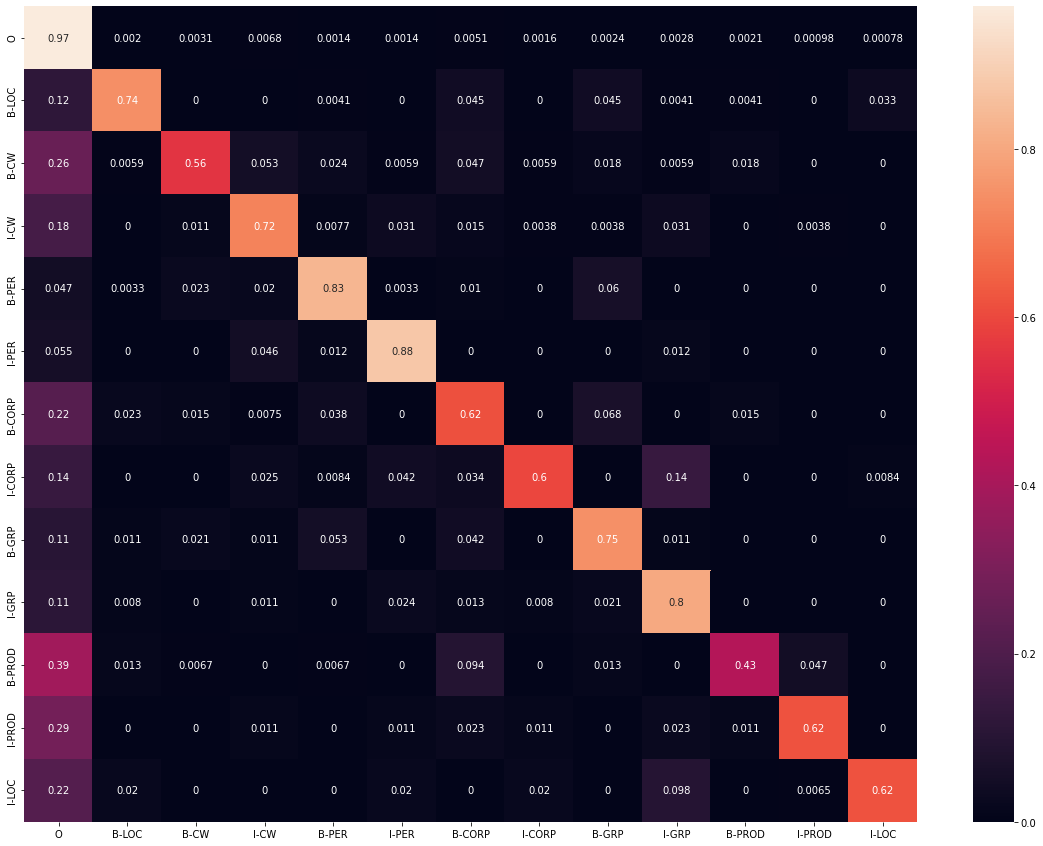

In [21]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

import seaborn as sn
import pandas as pd

classes = list(tag_to_ix.keys())

cf_matrix = confusion_matrix(tag_lst, tag_lst_pred, normalize = 'true')
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (20,15))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

## Word2Vec Pretrained Embeddings

In [ ]:
!gunzip /content/drive/MyDrive/Data/data/W2V/GoogleNews-vectors-negative300.bin.gz -d /content/drive/MyDrive/Data/data/W2V/

gzip: /content/drive/MyDrive/Data/data/W2V/ is a directory -- ignored


In [ ]:
model = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/Data/data/W2V/GoogleNews-vectors-negative300.bin', binary=True)

matrix_len = len(word_to_ix)
print('Number of Words:', len(word_to_ix))
weights_matrix = np.zeros((matrix_len, 300))
words_found = 0

for i, word in enumerate(word_to_ix.keys()):
    try: 
        weights_matrix[i] = model[word]
        words_found += 1
    except KeyError:
        weights_matrix[i] = np.random.normal(scale=0.5, size=(300, ))
print('Words found: ', words_found)
print('Weight matrix created!')
print()

Number of Words: 29966
Words found:  17516
Weight matrix created!



In [ ]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size,weights_matrix):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight = nn.Parameter(torch.tensor(weights_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence):
        embeds = self.embedding(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

print('Model has been built!')
print()

EMBEDDING_DIM=300
HIDDEN_DIM = 300
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_to_ix),weights_matrix).to(device)
loss_function = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(5):  
    for sentence, tags in tqdm(training_data):
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is, turn them into
        # Tensors of word indices.
        sentence_in = prepare_sequence(sentence, word_to_ix).to(device)
        targets = prepare_sequence(tags, tag_to_ix).to(device)

        # Step 3. Run our forward pass.
        tag_scores = model(sentence_in)

        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()
    print(loss)

def predict(indices):    
    for index in range(len(indices)):
        with torch.no_grad():
            inputs = prepare_sequence(dev_data[index][0], word_to_ix)
            inputs = inputs.to(device)
            tag_scores = model(inputs)
        values, target = torch.max(tag_scores, 1)
        target = np.array(target.to('cpu'))
        yield target

y_pred = list(predict([s for s, t in dev_data]))
y_true = [t for s, t in dev_data]

y_true_indexed = []
for tag in y_true:
    tag_lst=[]
    for i in tag:
        tag_lst.append(tag_to_ix[i])

    y_true_indexed.append(tag_lst)
y_true = y_true_indexed

tag_lst=[]
for tag in y_true:

    for i in tag:
        tag_lst.append(i)

tag_lst_pred=[]
for tag in y_pred:

    for i in tag:
        tag_lst_pred.append(i)

report = classification_report(tag_lst, tag_lst_pred, target_names=tag_to_ix.keys())
print(report)


Model has been built!



100%|██████████| 14535/14535 [00:47<00:00, 303.50it/s]


tensor(0.1839, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 14535/14535 [00:51<00:00, 284.57it/s]


tensor(0.1548, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 14535/14535 [00:52<00:00, 276.45it/s]


tensor(0.0882, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 14535/14535 [00:52<00:00, 274.37it/s]


tensor(0.1139, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 14535/14535 [00:41<00:00, 346.76it/s]


tensor(0.3347, device='cuda:0', grad_fn=<NllLossBackward0>)
              precision    recall  f1-score   support

           O       0.91      0.98      0.95     10240
       B-LOC       0.75      0.50      0.60       243
        B-CW       0.54      0.28      0.37       170
        I-CW       0.60      0.40      0.48       261
       B-PER       0.72      0.61      0.66       300
       I-PER       0.78      0.66      0.71       329
      B-CORP       0.69      0.31      0.43       133
      I-CORP       0.65      0.42      0.51       119
       B-GRP       0.52      0.42      0.47       190
       I-GRP       0.73      0.67      0.70       377
      B-PROD       0.58      0.28      0.37       149
      I-PROD       0.75      0.31      0.44        87
       I-LOC       0.75      0.41      0.53       153

    accuracy                           0.88     12751
   macro avg       0.69      0.48      0.55     12751
weighted avg       0.87      0.88      0.87     12751



## BiLSTM with W2V 

In [ ]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size,weights_matrix):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight = nn.Parameter(torch.tensor(weights_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional = True)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim*2, tagset_size)

    def forward(self, sentence):
        embeds = self.embedding(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

print('Model has been built!')
print()

EMBEDDING_DIM=300
HIDDEN_DIM = 300
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_to_ix),weights_matrix).to(device)
loss_function = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(5):  
    for sentence, tags in tqdm(training_data):
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is, turn them into
        # Tensors of word indices.
        sentence_in = prepare_sequence(sentence, word_to_ix).to(device)
        targets = prepare_sequence(tags, tag_to_ix).to(device)

        # Step 3. Run our forward pass.
        tag_scores = model(sentence_in)

        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()
    print(loss)

def predict(indices):    
    for index in range(len(indices)):
        with torch.no_grad():
            inputs = prepare_sequence(dev_data[index][0], word_to_ix)
            inputs = inputs.to(device)
            tag_scores = model(inputs)
        values, target = torch.max(tag_scores, 1)
        target = np.array(target.to('cpu'))
        yield target

y_pred = list(predict([s for s, t in dev_data]))
y_true = [t for s, t in dev_data]

y_true_indexed = []
for tag in y_true:
    tag_lst=[]
    for i in tag:
        tag_lst.append(tag_to_ix[i])

    y_true_indexed.append(tag_lst)
y_true = y_true_indexed

tag_lst=[]
for tag in y_true:

    for i in tag:
        tag_lst.append(i)

tag_lst_pred=[]
for tag in y_pred:

    for i in tag:
        tag_lst_pred.append(i)

report = classification_report(tag_lst, tag_lst_pred, target_names=tag_to_ix.keys())
print(report)


Model has been built!



100%|██████████| 14535/14535 [01:02<00:00, 234.32it/s]


tensor(0.1699, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 14535/14535 [01:05<00:00, 222.04it/s]


tensor(0.1189, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 14535/14535 [01:02<00:00, 232.96it/s]


tensor(0.1209, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 14535/14535 [01:02<00:00, 234.36it/s]


tensor(0.0969, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 14535/14535 [01:01<00:00, 235.33it/s]


tensor(0.0068, device='cuda:0', grad_fn=<NllLossBackward0>)
              precision    recall  f1-score   support

           O       0.94      0.98      0.96     10240
       B-LOC       0.85      0.66      0.74       243
        B-CW       0.68      0.36      0.48       170
        I-CW       0.76      0.44      0.56       261
       B-PER       0.71      0.85      0.77       300
       I-PER       0.72      0.81      0.77       329
      B-CORP       0.89      0.47      0.61       133
      I-CORP       0.74      0.54      0.62       119
       B-GRP       0.77      0.54      0.63       190
       I-GRP       0.83      0.67      0.74       377
      B-PROD       0.59      0.34      0.43       149
      I-PROD       0.66      0.36      0.46        87
       I-LOC       0.78      0.61      0.68       153

    accuracy                           0.91     12751
   macro avg       0.76      0.59      0.65     12751
weighted avg       0.90      0.91      0.90     12751



## LSTM with 2 Layers and Dropout with W2V

In [ ]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size,weights_matrix):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight = nn.Parameter(torch.tensor(weights_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers = 2, dropout = 0.2)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence):
        embeds = self.embedding(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

print('Model has been built!')
print()

EMBEDDING_DIM=300
HIDDEN_DIM = 300
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_to_ix),weights_matrix).to(device)
loss_function = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(5):  
    for sentence, tags in tqdm(training_data):
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is, turn them into
        # Tensors of word indices.
        sentence_in = prepare_sequence(sentence, word_to_ix).to(device)
        targets = prepare_sequence(tags, tag_to_ix).to(device)

        # Step 3. Run our forward pass.
        tag_scores = model(sentence_in)

        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()
    print(loss)

def predict(indices):    
    for index in range(len(indices)):
        with torch.no_grad():
            inputs = prepare_sequence(dev_data[index][0], word_to_ix)
            inputs = inputs.to(device)
            tag_scores = model(inputs)
        values, target = torch.max(tag_scores, 1)
        target = np.array(target.to('cpu'))
        yield target

y_pred = list(predict([s for s, t in dev_data]))
y_true = [t for s, t in dev_data]

y_true_indexed = []
for tag in y_true:
    tag_lst=[]
    for i in tag:
        tag_lst.append(tag_to_ix[i])

    y_true_indexed.append(tag_lst)
y_true = y_true_indexed

tag_lst=[]
for tag in y_true:

    for i in tag:
        tag_lst.append(i)

tag_lst_pred=[]
for tag in y_pred:

    for i in tag:
        tag_lst_pred.append(i)

report = classification_report(tag_lst, tag_lst_pred, target_names=tag_to_ix.keys())
print(report)


Model has been built!



100%|██████████| 14535/14535 [01:07<00:00, 216.43it/s]


tensor(0.2105, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 14535/14535 [01:05<00:00, 223.06it/s]


tensor(0.1446, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 14535/14535 [01:05<00:00, 223.42it/s]


tensor(0.1760, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 14535/14535 [01:05<00:00, 222.92it/s]


tensor(0.0879, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 14535/14535 [01:04<00:00, 225.22it/s]


tensor(0.0854, device='cuda:0', grad_fn=<NllLossBackward0>)
              precision    recall  f1-score   support

           O       0.93      0.96      0.95     10240
       B-LOC       0.61      0.66      0.63       243
        B-CW       0.51      0.29      0.37       170
        I-CW       0.57      0.38      0.46       261
       B-PER       0.66      0.64      0.65       300
       I-PER       0.74      0.82      0.78       329
      B-CORP       0.36      0.41      0.38       133
      I-CORP       0.44      0.61      0.51       119
       B-GRP       0.60      0.38      0.46       190
       I-GRP       0.79      0.65      0.71       377
      B-PROD       0.59      0.24      0.34       149
      I-PROD       0.76      0.37      0.50        87
       I-LOC       0.71      0.59      0.65       153

    accuracy                           0.88     12751
   macro avg       0.64      0.54      0.57     12751
weighted avg       0.87      0.88      0.88     12751



## BiLSTM with 2 Layers and Dropout and W2V 

In [ ]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size,weights_matrix):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight = nn.Parameter(torch.tensor(weights_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers = 2, dropout = 0.2, bidirectional = True)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim*2, tagset_size)

    def forward(self, sentence):
        embeds = self.embedding(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

print('Model has been built!')
print()

EMBEDDING_DIM=300
HIDDEN_DIM = 300
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_to_ix),weights_matrix).to(device)
loss_function = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(5):  
    for sentence, tags in tqdm(training_data):
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is, turn them into
        # Tensors of word indices.
        sentence_in = prepare_sequence(sentence, word_to_ix).to(device)
        targets = prepare_sequence(tags, tag_to_ix).to(device)

        # Step 3. Run our forward pass.
        tag_scores = model(sentence_in)

        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()
    print(loss)

def predict(indices):    
    for index in range(len(indices)):
        with torch.no_grad():
            inputs = prepare_sequence(dev_data[index][0], word_to_ix)
            inputs = inputs.to(device)
            tag_scores = model(inputs)
        values, target = torch.max(tag_scores, 1)
        target = np.array(target.to('cpu'))
        yield target

y_pred = list(predict([s for s, t in dev_data]))
y_true = [t for s, t in dev_data]

y_true_indexed = []
for tag in y_true:
    tag_lst=[]
    for i in tag:
        tag_lst.append(tag_to_ix[i])

    y_true_indexed.append(tag_lst)
y_true = y_true_indexed

tag_lst=[]
for tag in y_true:

    for i in tag:
        tag_lst.append(i)

tag_lst_pred=[]
for tag in y_pred:

    for i in tag:
        tag_lst_pred.append(i)

report = classification_report(tag_lst, tag_lst_pred, target_names=tag_to_ix.keys())
print(report)


Model has been built!



100%|██████████| 14535/14535 [01:48<00:00, 134.01it/s]


tensor(0.1661, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 14535/14535 [01:49<00:00, 133.29it/s]


tensor(0.0821, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 14535/14535 [01:48<00:00, 134.19it/s]


tensor(0.0963, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 14535/14535 [01:49<00:00, 132.38it/s]


tensor(0.2386, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 14535/14535 [01:48<00:00, 133.79it/s]


tensor(0.0223, device='cuda:0', grad_fn=<NllLossBackward0>)
              precision    recall  f1-score   support

           O       0.95      0.98      0.96     10240
       B-LOC       0.72      0.80      0.76       243
        B-CW       0.77      0.34      0.47       170
        I-CW       0.87      0.39      0.54       261
       B-PER       0.68      0.86      0.76       300
       I-PER       0.72      0.90      0.80       329
      B-CORP       0.72      0.56      0.63       133
      I-CORP       0.73      0.57      0.64       119
       B-GRP       0.85      0.58      0.69       190
       I-GRP       0.87      0.70      0.78       377
      B-PROD       0.68      0.44      0.53       149
      I-PROD       0.63      0.45      0.52        87
       I-LOC       0.84      0.71      0.77       153

    accuracy                           0.91     12751
   macro avg       0.77      0.64      0.68     12751
weighted avg       0.91      0.91      0.91     12751



## Bi-LSTM CRF

In [ ]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(1)

In [ ]:
def argmax(vec):
    # return the argmax as a python int
    _, idx = torch.max(vec, 1)
    return idx.item()


def prepare_sequence(seq, to_ix):
    idxs = []
    for w in seq:
        try:
            idxs.append(to_ix[w])
        except:
            idxs.append(to_ix['<UNK>'])

        
    return torch.tensor(idxs, dtype=torch.long)

# Compute log sum exp in a numerically stable way for the forward algorithm
def log_sum_exp(vec):
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + \
        torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))

In [ ]:
class BiLSTM_CRF(nn.Module):

    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim,weights_matrix):
        super(BiLSTM_CRF, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)

        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight = nn.Parameter(torch.tensor(weights_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False

        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2,
                            num_layers=2, dropout = 0.2, bidirectional=True)

        # Maps the output of the LSTM into tag space.
        self.hidden2tag = nn.Linear(hidden_dim, self.tagset_size)

        # Matrix of transition parameters.  Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter(
            torch.randn(self.tagset_size, self.tagset_size))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

        self.hidden = self.init_hidden()

    def init_hidden(self):
        return (torch.randn(4, 1, self.hidden_dim // 2),
                torch.randn(4, 1, self.hidden_dim // 2))

    def _forward_alg(self, feats):
        # Do the forward algorithm to compute the partition function
        init_alphas = torch.full((1, self.tagset_size), -10000.)
        # START_TAG has all of the score.
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

        # Wrap in a variable so that we will get automatic backprop
        forward_var = init_alphas

        # Iterate through the sentence
        for feat in feats:
            alphas_t = []  # The forward tensors at this timestep
            for next_tag in range(self.tagset_size):
                # broadcast the emission score: it is the same regardless of
                # the previous tag
                emit_score = feat[next_tag].view(
                    1, -1).expand(1, self.tagset_size)
                # the ith entry of trans_score is the score of transitioning to
                # next_tag from i
                trans_score = self.transitions[next_tag].view(1, -1)
                # The ith entry of next_tag_var is the value for the
                # edge (i -> next_tag) before we do log-sum-exp
                next_tag_var = forward_var + trans_score + emit_score
                # The forward variable for this tag is log-sum-exp of all the
                # scores.
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        alpha = log_sum_exp(terminal_var)
        return alpha

    def _get_lstm_features(self, sentence):
        self.hidden = self.init_hidden()
        embeds = self.embedding(sentence).view(len(sentence), 1, -1)
        lstm_out, self.hidden = self.lstm(embeds, self.hidden)
        lstm_out = lstm_out.view(len(sentence), self.hidden_dim)
        lstm_feats = self.hidden2tag(lstm_out)
        return lstm_feats

    def _score_sentence(self, feats, tags):
        # Gives the score of a provided tag sequence
        score = torch.zeros(1)
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long), tags])
        for i, feat in enumerate(feats):
            score = score + \
                self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000.)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        forward_var = init_vvars
        for feat in feats:
            bptrs_t = []  # holds the backpointers for this step
            viterbivars_t = []  # holds the viterbi variables for this step

            for next_tag in range(self.tagset_size):
                # next_tag_var[i] holds the viterbi variable for tag i at the
                # previous step, plus the score of transitioning
                # from tag i to next_tag.
                # We don't include the emission scores here because the max
                # does not depend on them (we add them in below)
                next_tag_var = forward_var + self.transitions[next_tag]
                best_tag_id = argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            # Now add in the emission scores, and assign forward_var to the set
            # of viterbi variables we just computed
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)

        # Transition to STOP_TAG
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path

    def neg_log_likelihood(self, sentence, tags):
        feats = self._get_lstm_features(sentence)
        forward_score = self._forward_alg(feats)
        gold_score = self._score_sentence(feats, tags)
        return forward_score - gold_score

    def forward(self, sentence):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        lstm_feats = self._get_lstm_features(sentence)

        # Find the best path, given the features.
        score, tag_seq = self._viterbi_decode(lstm_feats)
        return score, tag_seq

In [ ]:
START_TAG = "<START>"
STOP_TAG = "<STOP>"
EMBEDDING_DIM = 300
HIDDEN_DIM = 300
lr=0.1
weight_decay=1e-4

word_to_ix = {}
# For each words-list (sentence) and tags-list in each tuple of training_data
for sent, tags in training_data:
    for word in sent:
        if word not in word_to_ix:  # word has not been assigned an index yet
            word_to_ix[word] = len(word_to_ix)  # Assign each word with a unique index

word_to_ix['<UNK>'] = len(word_to_ix)

tag_to_ix = {'B-CORP': 6,
 'B-CW': 2,
 'B-GRP': 8,
 'B-LOC': 1,
 'B-PER': 4,
 'B-PROD': 10,
 'I-CORP': 7,
 'I-CW': 3,
 'I-GRP': 9,
 'I-LOC': 12,
 'I-PER': 5,
 'I-PROD': 11,
 'O': 0,
 START_TAG: 13, 
 STOP_TAG: 14}

model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM,weights_matrix)
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)


path = "/content/drive/MyDrive/Data/data/model.pt"
prev_loss = 100
prev_macro_f1 = 0
# Make sure prepare_sequence from earlier in the LSTM section is loaded
for epoch in range(5):  # again, normally you would NOT do 300 epochs, it is toy data
    for sentence, tags in tqdm(training_data):
        
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is,
        # turn them into Tensors of word indices.
        sentence_in = prepare_sequence(sentence, word_to_ix)
        targets = torch.tensor([tag_to_ix[t] for t in tags], dtype=torch.long)

        # Step 3. Run our forward pass.
        loss = model.neg_log_likelihood(sentence_in, targets)

        # Step 4. Compute the loss, gradients, and update the parameters by
        # calling optimizer.step()
        loss.backward()

        if loss<=1:
          lr = 0.001

        optimizer.step()
        

    def predict(indices):    
        for index in range(len(indices)):
            with torch.no_grad():
                inputs = prepare_sequence(dev_data[index][0], word_to_ix)
                
                tag_scores = model(inputs)
            target = tag_scores[1]
            yield target

    y_pred = list(predict([s for s, t in dev_data]))
    y_true = [t for s, t in dev_data]

    y_true_indexed = []
    for tag in y_true:
        tag_lst=[]
        for i in tag:
            tag_lst.append(tag_to_ix[i])

        y_true_indexed.append(tag_lst)
    y_true = y_true_indexed

    tag_lst=[]
    for tag in y_true:

        for i in tag:
            tag_lst.append(i)

    tag_lst_pred=[]
    for tag in y_pred:

        for i in tag:
            tag_lst_pred.append(i)
    tag_to_ix = {'B-CORP': 6,
                  'B-CW': 2,
                  'B-GRP': 8,
                  'B-LOC': 1,
                  'B-PER': 4,
                  'B-PROD': 10,
                  'I-CORP': 7,
                  'I-CW': 3,
                  'I-GRP': 9,
                  'I-LOC': 12,
                  'I-PER': 5,
                  'I-PROD': 11,
                  'O': 0}
    report = classification_report(tag_lst, tag_lst_pred, target_names=tag_to_ix.keys())
    macro_f1 = float(report.split(' ')[512])
        
    if prev_macro_f1<macro_f1:
      torch.save(model.state_dict(), path)
      prev_macro_f1 = macro_f1
      rev_loss = loss
      print('Best model saved!')
    elif prev_macro_f1==macro_f1 and loss<prev_loss:
      torch.save(model.state_dict(), path)
      prev_loss = loss
      print('Best model saved!')

    tag_to_ix = {'B-CORP': 6,
                  'B-CW': 2,
                  'B-GRP': 8,
                  'B-LOC': 1,
                  'B-PER': 4,
                  'B-PROD': 10,
                  'I-CORP': 7,
                  'I-CW': 3,
                  'I-GRP': 9,
                  'I-LOC': 12,
                  'I-PER': 5,
                  'I-PROD': 11,
                  'O': 0,
                  START_TAG: 13,
                  STOP_TAG: 14}

    print('Loss: ', loss, 'F1_Score: ', macro_f1)

100%|██████████| 14535/14535 [20:20<00:00, 11.91it/s]


Best model saved!
Loss:  tensor([5.1478], grad_fn=<SubBackward0>) F1_Score:  0.62


100%|██████████| 14535/14535 [20:27<00:00, 11.85it/s]


Loss:  tensor([5.2193], grad_fn=<SubBackward0>) F1_Score:  0.61


100%|██████████| 14535/14535 [20:26<00:00, 11.85it/s]


Best model saved!
Loss:  tensor([3.4073], grad_fn=<SubBackward0>) F1_Score:  0.67


100%|██████████| 14535/14535 [20:27<00:00, 11.84it/s]


Loss:  tensor([4.6100], grad_fn=<SubBackward0>) F1_Score:  0.62


100%|██████████| 14535/14535 [20:36<00:00, 11.75it/s]


Loss:  tensor([1.8289], grad_fn=<SubBackward0>) F1_Score:  0.65


In [ ]:
model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM,weights_matrix)
model.load_state_dict(torch.load(path))
def predict(indices):    
    for index in range(len(indices)):
        with torch.no_grad():
            inputs = prepare_sequence(dev_data[index][0], word_to_ix)
            
            tag_scores = model(inputs)
        target = tag_scores[1]
        yield target

def accuracy_score(y_true, y_pred):
    y_pred = np.concatenate(tuple(y_pred))
    y_true = np.concatenate(tuple([[t for t in y] for y in y_true])).reshape(y_pred.shape)
    return (y_true == y_pred).sum() / float(len(y_true))

y_pred = list(predict([s for s, t in dev_data]))
y_true = [t for s, t in dev_data]

y_true_indexed = []
for tag in y_true:
    tag_lst=[]
    for i in tag:
        tag_lst.append(tag_to_ix[i])

    y_true_indexed.append(tag_lst)
y_true = y_true_indexed

tag_lst=[]
for tag in y_true:

    for i in tag:
        tag_lst.append(i)

tag_lst_pred=[]
for tag in y_pred:

    for i in tag:
        tag_lst_pred.append(i)
tag_to_ix = {'B-CORP': 6,
 'B-CW': 2,
 'B-GRP': 8,
 'B-LOC': 1,
 'B-PER': 4,
 'B-PROD': 10,
 'I-CORP': 7,
 'I-CW': 3,
 'I-GRP': 9,
 'I-LOC': 12,
 'I-PER': 5,
 'I-PROD': 11,
 'O': 0}
report = classification_report(tag_lst, tag_lst_pred, target_names=tag_to_ix.keys())
print(report)

              precision    recall  f1-score   support

      B-CORP       0.90      0.99      0.95     10240
        B-CW       0.71      0.68      0.69       243
       B-GRP       0.63      0.15      0.25       170
       B-LOC       0.67      0.13      0.22       261
       B-PER       0.85      0.78      0.81       300
      B-PROD       0.85      0.79      0.82       329
      I-CORP       0.93      0.32      0.47       133
        I-CW       0.93      0.24      0.38       119
       I-GRP       0.84      0.46      0.59       190
       I-LOC       0.88      0.53      0.66       377
       I-PER       0.72      0.12      0.21       149
      I-PROD       0.74      0.20      0.31        87
           O       0.65      0.54      0.59       153

    accuracy                           0.89     12751
   macro avg       0.79      0.45      0.53     12751
weighted avg       0.88      0.89      0.87     12751



# References

[pytorch lstm](https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html)